<h1>TikTok Analysis - Part 1</h1>
<h2><i>Data Preparation</i></h2>

In [1]:
### Imports ###
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import style
style.use('ggplot')
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
import torch
from transformers import pipeline
from tqdm import tqdm
import pytz
import re
from nltk.stem.porter import PorterStemmer

### Set necessary workspace variables ###

# Set execution type (to avoid repeating resource intensive operations)
#RUN_TYPE = 0 # set to 0 to avoid file creation process
RUN_TYPE = 1 # set to 1 to perform emotion analysis file creation process
#RUN_TYPE = 2 # set to 2 to perform topic analysis file creation process

# Define Ekman's emotions 
ekman_emotions = ['anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise']

# Timezones
eastern = pytz.timezone("US/Eastern")
european = pytz.timezone("Europe/Berlin")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aklei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
### Read and transform data (total_engagement, combined_text, set_timezone) ###
# Read dataframe
if RUN_TYPE == 1:
    df_tiktok = pd.read_excel('../data/tiktok/tiktok_transcript.xlsx').drop(columns=['Hashtag', 'URL', 'Author']).dropna()

    # Extract total_engagement and combine text columns
    df_tiktok['total_engagement'] = df_tiktok['Likes'] + df_tiktok['Comments'] + df_tiktok['Shares']
    df_tiktok['combined_text'] = df_tiktok['CaptionCleaned'].fillna('') + ' ' + df_tiktok['Transcript'].fillna('')
    df_tiktok.drop(columns=['Likes', 'Comments', 'Shares', 'Caption', 'CaptionCleaned', 'Transcript'], inplace=True)

    # Convert 'Date' column to datetime format and set timezone
    df_tiktok = df_tiktok.rename(columns={'Created': 'timestamp'})
    df_tiktok['timestamp'] = pd.to_datetime(
        df_tiktok['timestamp'],
        format="%a %b %d %H:%M:%S %z %Y",
        errors='coerce'
    )
    df_tiktok['timestamp'] = df_tiktok['timestamp'].dt.tz_localize(eastern)

    print(f"Länge df: {len(df_tiktok)}")
    print(f"Columns: {df_tiktok.columns.tolist()}")

Länge df: 334
Columns: ['timestamp', 'total_engagement', 'combined_text']


In [3]:
### Prepare data for analysis (normalize text) ###
if RUN_TYPE == 1:
    # 1. Set Classifier
    # Load Hugging Face's emotion classifier
    print("[Info]")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    classifier = pipeline("text-classification", model="bhadresh-savani/bert-base-uncased-emotion", top_k=None, device=0 if device == "cuda" else -1)

    # 2. Functions to clean and process text data
    # Removing noise from the text
    def remove_noise(text):
        text = text.lower()
        text = re.sub(r"https\S+|www\S+httpss\S+", '', text, flags=re.MULTILINE) # Remove Url
        text = re.sub(r"\@w+|\#", '', text) # remove @ and #
        text = re.sub(r"[^\w\s]", '', text) # remove punctuation
        text_tokens = text.split()
        filtered_text = [w for w in text_tokens if not w in stop_words]
        return " ".join(filtered_text)

    # Reduction of dimensionality by abstracting word to word stem and truncating text
    stemmer = PorterStemmer()
    def stem_words(text):
        words = text.split()
        stemmed_text = [stemmer.stem(word) for word in words]
        return stemmed_text

    def truncate_text(text, max_length=512):
        words = text.split()
        return " ".join(words[:max_length])

[Info]


Device set to use cpu


In [4]:
### Prepare data for analysis (append emotions) ###
if RUN_TYPE == 1:
    # 3. Computing and appending emotions to dataframe
    def compute_emotions(text):
        if not isinstance(text, str) or text.strip() == "":
            print("[ComputeEmotions] Empty cell after data cleaning. Returning 0.0 for all emotions.")
            return {emotion: 0.0 for emotion in ekman_emotions}

        try:
            # Classify emotions using the Hugging Face pipeline and handle errors
            results = classifier(text)[0]
            if not results or not isinstance(results, list) or len(results[0]) == 0:
                return {emotion: 0.0 for emotion in ekman_emotions}

            emotion_scores = {result['label']: result['score'] for result in results}
            return {emotion: emotion_scores.get(emotion, 0.0) for emotion in ekman_emotions}

        except Exception as e:
            print(f"[ComputeEmotions] Error while processing text: {text[:20]}... Error: {e}")
            return {emotion: 0.0 for emotion in ekman_emotions}

    def append_emotions(df: pd.DataFrame, text_column: str) -> pd.DataFrame:
        if text_column not in df.columns:
            raise ValueError(f"[AppendEmotions] Column '{text_column}' not found in DataFrame.")

        print("[AppendEmotions] Computing emotions for column:", text_column)

        cleaned_column = f"{text_column}_cleaned"
        df[cleaned_column] = df[text_column].apply(
            lambda x: " ".join(stem_words(remove_noise(x))) if isinstance(x, str) and x.strip() else ""
        )

        # Truncate text if cleaned text exceeds 512 tokens
        if (df[cleaned_column].str.split().str.len() > 512).any():
            print("[AppendEmotions] At least one row with more than 512 tokens - truncating text ...")
            df[cleaned_column] = df[cleaned_column].apply(lambda x: truncate_text(x, max_length=512))

        emotion_scores = [compute_emotions(text) for text in tqdm(df[cleaned_column], desc="[AppendEmotions] Processing emotions")]
        emotions_df = pd.DataFrame(emotion_scores)
        emotions_df.index = df.index
        emotions_df.columns = [f"{text_column}_{emotion}" for emotion in ekman_emotions]

        # Add dominant emotion column
        dominant = emotions_df.idxmax(axis=1).apply(lambda x: x.split('_')[-1])
        all_zero = emotions_df.eq(0.0).all(axis=1)
        dominant[all_zero] = np.nan
        emotions_df[f"{text_column}_dominant_emotion"] = dominant

        # Insert right hand of input text_column
        insert_at = df.columns.get_loc(text_column) + 1

        # DataFrame in drei Teile splitten und zusammenfügen
        left = df.iloc[:, :insert_at]
        right = df.iloc[:, insert_at:].drop(columns=[cleaned_column], errors='ignore')
        result_df = pd.concat([left, df[[cleaned_column]], emotions_df, right], axis=1)

        return result_df

[AppendEmotions] Computing emotions for column: combined_text
[AppendEmotions] At least one row with more than 512 tokens - truncating text ...


[AppendEmotions] Processing emotions:   3%|▎         | 10/334 [00:01<00:27, 11.70it/s]

[ComputeEmotions] Error while processing text: se qu sin agua el sa... Error: The size of tensor a (563) must match the size of tensor b (512) at non-singleton dimension 1


[AppendEmotions] Processing emotions:  17%|█▋        | 57/334 [00:04<00:14, 19.22it/s]

[ComputeEmotions] Error while processing text: tiktokl live livehig... Error: The size of tensor a (683) must match the size of tensor b (512) at non-singleton dimension 1


[AppendEmotions] Processing emotions:  25%|██▍       | 82/334 [00:05<00:13, 19.08it/s]

[ComputeEmotions] Error while processing text: first look insid spa... Error: The size of tensor a (620) must match the size of tensor b (512) at non-singleton dimension 1


[AppendEmotions] Processing emotions:  46%|████▌     | 154/334 [00:11<00:13, 13.07it/s]

[ComputeEmotions] Error while processing text: илон маск придумал н... Error: The size of tensor a (860) must match the size of tensor b (512) at non-singleton dimension 1


[AppendEmotions] Processing emotions:  67%|██████▋   | 225/334 [00:17<00:09, 11.40it/s]

[ComputeEmotions] Error while processing text: repli jimmi goedkneg... Error: The size of tensor a (712) must match the size of tensor b (512) at non-singleton dimension 1
[ComputeEmotions] Error while processing text: good time invest tes... Error: The size of tensor a (797) must match the size of tensor b (512) at non-singleton dimension 1


[AppendEmotions] Processing emotions:  93%|█████████▎| 312/334 [00:25<00:01, 14.04it/s]

[ComputeEmotions] Error while processing text: je sui fan omgg tu p... Error: The size of tensor a (619) must match the size of tensor b (512) at non-singleton dimension 1


[AppendEmotions] Processing emotions:  96%|█████████▋| 322/334 [00:26<00:00, 15.79it/s]

[ComputeEmotions] Error while processing text: le tesla model pi un... Error: The size of tensor a (904) must match the size of tensor b (512) at non-singleton dimension 1


[AppendEmotions] Processing emotions: 100%|██████████| 334/334 [00:27<00:00, 12.18it/s]


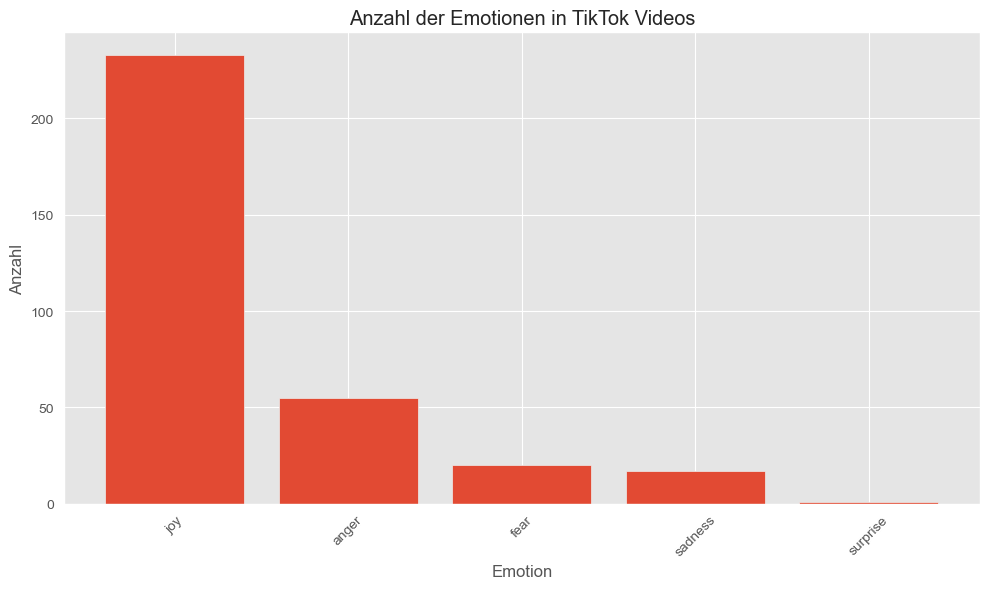

Anzahl der Videos: 334
Anzahl Emotionen in Videos:
combined_text_dominant_emotion
joy         233
anger        55
fear         20
sadness      17
surprise      1
Name: count, dtype: int64


In [5]:
### Create/Read dataset: Performing emotion analysis ###
if RUN_TYPE == 1:
    # Append emotions to TikTok DataFrame and safe to file
    df_tiktok = append_emotions(df_tiktok, 'combined_text')
    df_tiktok.to_csv('../data/tiktok/tiktok_emotions.csv', index=False)

df_tiktok_emotions = pd.read_csv('../data/tiktok/tiktok_emotions.csv')

# Count dominant emotions
emotion_counts = df_tiktok_emotions['combined_text_dominant_emotion'].value_counts()

# Plot emotions in barchart
plt.figure(figsize=(10, 6))
plt.bar(emotion_counts.index, emotion_counts.values)
plt.title('Anzahl der Emotionen in TikTok Videos')
plt.xlabel('Emotion')
plt.ylabel('Anzahl')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Zeige die Zahlen
print(f"Anzahl der Videos: {len(df_tiktok_emotions)}")
print(f"Anzahl Emotionen in Videos:\n{emotion_counts}")

<h1>TikTok Analysis - Part 2</h1>
<h2><i>Event Study</i></h2>
<h3>[2.1][Data Preparation]</h3>

In [6]:
### Read necessary data for event study (tiktok, us_stock_data, ger_stock_data) ###
if RUN_TYPE == 1:
    # TikTok data
    # see above

    # Stock data (US)
    df_us_stock_data = pd.read_csv('../legacy/data/tsla_intraday_202305_202504-1m.csv')
    df_us_stock_data = df_us_stock_data.rename(
        columns={'Unnamed: 0': 'timestamp'}
    )
    df_us_stock_data['timestamp'] = pd.to_datetime(
        df_us_stock_data['timestamp']
    ).dt.tz_localize(
        tz=eastern
    )
    df_us_stock_data['timestamp'].copy().sort_values(ascending=True, inplace=True)
    df_us_stock_data.set_index('timestamp').sort_index()

    # Stock data (GER)
    df_ger_stock_data = pd.read_csv('../legacy/data/TSL0_intraday_230501_250501-1m.csv').drop(columns=['Unnamed: 0'])
    df_ger_stock_data = df_ger_stock_data.rename(
        columns={'datetime': 'timestamp'}
    )

    df_ger_stock_data['timestamp'] = pd.to_datetime(
        df_ger_stock_data['timestamp']
    ).dt.tz_localize(
        tz=european
    )
    df_ger_stock_data.set_index('timestamp').sort_index()

    # Save to file
    df_tiktok_emotions.to_csv('../data/tiktok/tiktok_emotions.csv', index=False)

    df_ger_stock_data.head()

<h3>[2.2][Log Transformation]</h3>
<p>In the following, similarly to the twitter data analysis, we compute the log_return and log_volume for the fin data. Since in the tsl0_intraday data file we have some points in time without data, we also need to fill it. For this, we use the foreward fill ffill() method for the return and set the volume to 0 for the new tuple.</p>

In [7]:
### Foreward fill missing values in stock data ###
if RUN_TYPE == 1:
    def fill_missing_timestamps(df):
        df = df.copy()

        if df.index.name != 'timestamp':
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df = df.set_index('timestamp').sort_index()

        start_time = df.index.min()
        end_time = df.index.max()

        # Filter trading hours
        full_index = pd.date_range(
            start=start_time.replace(hour=4, minute=0, second=0, microsecond=0),
            end=end_time.replace(hour=22, minute=59, second=0, microsecond=0),
            freq='1min'
        )

        # Filter business days
        business_minutes = full_index[full_index.dayofweek < 5]

        # Reindex and fill data
        df_filled = df.reindex(business_minutes)

        # Forward fill prices
        price_cols = ['open', 'high', 'low', 'close']
        df_filled[price_cols] = df_filled[price_cols].ffill()

        # Fill Volume with 0
        df_filled['volume'] = df_filled['volume'].fillna(0)

        return df_filled

    def compute_stock_measures(df, last_date='2025-04-30'):

        # Check if DataFrame is already processed
        required_columns = [
            'log_return', 'log_volume', 'log_volume_z', 'minute_of_day'
        ]

        if all(col in df.columns for col in required_columns):
            print("[Info] Daten bereits vollständig verarbeitet")

            # Check date
            cutoff_timestamp = pd.Timestamp(f'{last_date} 22:59:00', tz=df.index.tz)
            if df.index.max() > cutoff_timestamp:
                print(f"[Info] Schneide Daten nach {last_date} ab")
                df = df[df.index <= cutoff_timestamp]

            return df

        # Fill missing timestamps
        df = fill_missing_timestamps(df)

        # Filter data until last_date
        cutoff_timestamp = pd.Timestamp(f'{last_date} 22:59:00', tz=df.index.tz)
        df = df[df.index <= cutoff_timestamp]

        # Compute missing column values
        if 'minute_of_day' not in df.columns:
            df['minute_of_day'] = df.index.hour * 60 + df.index.minute

        if 'log_return' not in df.columns:
            df['log_return'] = np.log(df['close'] / df['close'].shift(1))

        if 'log_volume' not in df.columns:
            df['log_volume'] = np.log1p(df['volume'])
            df['log_volume_z'] = (df['log_volume'] - df['log_volume'].mean()) / df['log_volume'].std()
        return df

In [9]:
### Compute stock measures (log_return/volume) for US and GER stock data + forward fill fin data ###
# Create new csv files
if RUN_TYPE == 1:
    df_us_stock_data = compute_stock_measures(df_us_stock_data).drop(columns={'open', 'high', 'low', 'close'})
    df_us_stock_data.to_csv(
        path_or_buf='../data/stocks/tesla_nyse_intraday_202305_202504-1m.csv',
        index=True
    )

    df_ger_stock_data = compute_stock_measures(df_ger_stock_data).drop(columns={'open', 'high', 'low', 'close'})
    df_ger_stock_data.to_csv(
        path_or_buf='../data/stocks/tesla_xetra_intraday_202305_202504-1m.csv',
        index=True
    )

[Info] Daten bereits vollständig verarbeitet
[Info] Daten bereits vollständig verarbeitet
